<a href="https://colab.research.google.com/github/jegraham/Phase-0-Original-AutoEncoder/blob/main/Graham%2C_Jessica_GAE_Clustering_Phase_1_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple K-Means GAE Implementation (Step 1)

This is the initial GAE implementation using encoders and decoders. Parameters can be modified under the 'Testing Parameters' Section and will be implemented throughout the code.

## Import

### Import Libraries

In [1]:
import os
import os.path as osp
import shutil # -> For copying a directory
import pandas as pd # -> For data structure and file manipulation
import random
import datetime

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [2]:
#Import the remaining files as needed
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# GPU Usage Guide - https://medium.com/@natsunoyuki/speeding-up-model-training-with-google-colab-b1ad7c48573e
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

#!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
#print('uninstall')

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install --verbose torch-scatter
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric pandas
!pip install scikit-learn
#!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}.html



import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist, squareform
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, FeatureAgglomeration, SpectralCoclustering, MiniBatchKMeans, Birch, DBSCAN, OPTICS, AgglomerativeClustering, DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, InMemoryDataset, download_url
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GAE
from torch_geometric.utils import train_test_split_edges, from_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures, ToDevice, RandomLinkSplit
import torch.nn.functional as F


2.0.1+cu118
Using cuda.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 51.5 MB/s eta 0:00:00
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 61.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import the Dataset

Process the Data Frame - Modified Code from - https://github.com/jegraham/csv_to_dataframe_to_graph/blob/master/.idea/csv_to_datadrame_conversion.py

In [3]:
# Import the Data
from google.colab import files
uploaded = files.upload()
# uploaded = https://drive.google.com/file/d/1Ej2lijwlKM7pri5ebQ5hVl-Z5OtvWNbz/view?usp=share_link

file_name = next(iter(uploaded))
print(file_name)
df = pd.read_csv(file_name)
df = df.reset_index(drop=True)

Saving May 4th Dataset Car and Tower  - Sheet1.csv to May 4th Dataset Car and Tower  - Sheet1.csv
May 4th Dataset Car and Tower  - Sheet1.csv


## Testing Parameters

In [4]:
# Define the root directory where the dataset will be stored
root = './'

# Define the Number of Clusters
num_clusters = 5
n = 10 # n_init refers to the number of times the clustering algorithm will run different initializations
clusters = []

max_dist = 500

# Transform Parameters
transform_set = True
value_num = 0.1
test_num = 0.2

# Optimizer Parameters (learning rate)
learn_rate = 0.01

# Epochs or the number of generation/iterations of the training dataset
epochs = 100

# Setting up Colours for the test visualizations
colours_simp = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors_full = ["black" if c <= -1 else "b" if c == 0 else "g" if c == 1 else "r" if c == 2 else "c" if c == 3 else "m" if c == 4 else "y" if c == 5 else "k" for c in clusters]

# Start Session Time
start_time = datetime.datetime.now()

## InMemory Dataset

Convert Dataset to same format as Planetoid - https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html

In [5]:
#InMemoryDataset
class MyDataset(InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.filename = file_name
        super().__init__(root, transform, pre_transform)
        ## if the data exists in the processed dir, then it loads directly from there, if not, it will run process
        self.data = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.filename]

    @property
    def processed_file_names(self):
       return ['data.pt']

    def download(self):
        #get the data from the original folder and save it to the raw folder
        from_path = os.path.join(self.root, self.filename)
        to_path = dest = os.path.join(self.raw_dir, self.filename)
        df = pd.read_csv(from_path)
        df.reset_index(drop=True)
        df.to_csv(to_path,index=False)

    def read_file(self):
        #read file from raw folder, and clean it
        path = osp.join(self.raw_dir, self.filename)
        df = pd.read_csv(path)
        df = df.reset_index(drop=True)

        # Set the RSU and Tower to represent Infrastructure = 1, Car = 0
        df['Type'] = np.where((df['Car ID'].str.contains('Tower')) | (df['Car ID'].str.contains('RSU')), 1, 0)
        df = df.drop(columns=['Car ID'])
        return df

    def process(self):
        #read the file and transform it into a pytorch geometric Data
        df = self.read_file()
        x = torch.from_numpy(df.values).float()

        edge_source = []
        edge_target = []

        # Loop row by row to add the edges to the graph
        for i in range(len(df)):
            # Inner loop to iterate through all other vehicles
            for j in range(i+1, len(df)):
                  if i != j:
                    dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

                    # Distance between anything and the Car/Tower/RSU in question
                    # Max expecting 48205 connections
                    # (310*310/2) = 9988
                    # (= (311-310)/2) as we are not looking to connect to themselves and duplicate the connections
                    if 0 < dist <= max_dist:
                        edge_source.append(i)#No direction
                        edge_target.append(j)

        # Create PyTorch Geometric Data object
        data = Data(
            x=x,
            edge_index=torch.tensor([edge_source, edge_target])
            )
        torch.save(data, self.processed_paths[0])

## Build Graph & Adjacency Matrix

In [6]:
G = nx.Graph()
edge_index = []


# iterate through rows and add nodes to the graph
for i in range(len(df)):
    G.add_node(i, x=df.loc[i, 'X'], y=df.loc[i, 'Y'])


# Convert 'Car ID' column to numeric values
df['Car ID'] = pd.to_numeric(df['Car ID'], errors='coerce')

# Assign numeric IDs based on 'Car ID' column
car_ids = torch.tensor(df['Car ID'].values, dtype=torch.float)
vertex = car_ids  # Use 'Car ID' as the vertex tensor


# add nodes to the graph with their features
for i, row in df.iterrows():
    G.add_node(i, **row.to_dict())

# Loop row by row to add the edges to the graph
for i in range(len(df)):
   distances = []

   # Inner loop to iterate through all other vehicles
   for j in range(len(df)):
        if i == j:
            continue

        dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

        if 0 < dist <= max_dist:
          distances.append((dist, j))
        # print(distance)

   distances.sort()

   for k in range(len(distances)):
       G.add_edge(i, distances[k][1], weight=distances[k][0])

# print the graph
print(G.edges)
print(G)

[(0, 276), (0, 6), (0, 190), (0, 237), (0, 198), (0, 275), (0, 269), (0, 59), (0, 166), (0, 142), (0, 256), (0, 131), (0, 90), (0, 60), (0, 228), (0, 221), (0, 149), (0, 137), (0, 86), (0, 70), (0, 291), (0, 25), (0, 67), (0, 85), (0, 83), (0, 26), (0, 51), (0, 267), (1, 12), (1, 57), (1, 250), (1, 225), (1, 183), (1, 79), (1, 27), (1, 235), (1, 8), (1, 174), (1, 105), (1, 247), (1, 173), (1, 99), (1, 47), (1, 53), (1, 207), (1, 62), (1, 39), (1, 245), (2, 178), (2, 293), (2, 159), (2, 124), (2, 265), (2, 309), (2, 44), (2, 14), (2, 263), (2, 261), (2, 156), (2, 220), (2, 17), (2, 157), (2, 253), (2, 249), (2, 117), (2, 209), (2, 298), (2, 76), (2, 103), (2, 187), (2, 23), (2, 289), (2, 177), (2, 128), (2, 301), (2, 55), (2, 91), (2, 122), (2, 78), (2, 61), (2, 162), (2, 163), (2, 260), (2, 134), (2, 274), (3, 243), (3, 75), (3, 303), (3, 214), (3, 116), (3, 255), (3, 112), (3, 41), (3, 72), (3, 155), (3, 239), (3, 73), (3, 296), (3, 95), (3, 223), (3, 37), (3, 252), (4, 229), (4, 136)

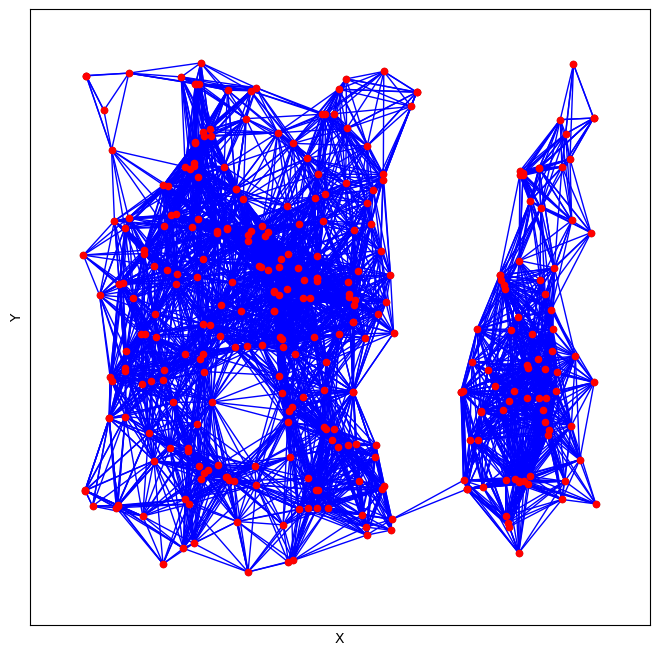

In [7]:
# Plotting Graph (Version 1)
X = df[['X', 'Y']].values

# create a layout for the graph nodes
pos = dict(zip(range(len(df)), X))

# draw the graph
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df['X'], df['Y'], s=20, color='grey')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='b', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

### Adjacency Matrix

<font color=#FF0000>
Is this needed? It works withouth this segment of code in the GAE.

In [8]:
dist_matrix = cdist(df[['X', 'Y']], df[['X', 'Y']])

# create an adjacency matrix where each node is connected to its three nearest neighbors
adj_matrix = np.zeros((len(df), len(df)))
for i in range(len(df)):
    sorted_indices = np.argsort(dist_matrix[i])[1:4]  # exclude self from nearest neighbors
    adj_matrix[i, sorted_indices] = 1
    adj_matrix[sorted_indices, i] = 1

# count the number of edges in the graph
num_edges = np.count_nonzero(adj_matrix) // 2  # divide by 2 since each edge is counted twice
print("Number of edges in the graph:", num_edges)
adj_matrix



edges = []
for i in range(adj_matrix.shape[0]):
    for j in range(i+1, adj_matrix.shape[1]):
        if adj_matrix[i][j] != 0:
            edges.append((i, j))


Number of edges in the graph: 586


## Graph AutoEncoder GAE

Graph AutoEncoders GAE &  
Variational Graph Autoencoders VGAE    

[Tutorial 6 paper](https://arxiv.org/pdf/1611.07308.pdf)  
[Tutorial 6 code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

### Load the data

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = RandomLinkSplit(
    num_val=value_num, num_test=test_num,
    is_undirected=True,
    split_labels=True
    )
if transform_set:
   dataset = MyDataset(root,file_name,transform=T.NormalizeFeatures())
else:
   dataset = MyDataset(root,file_name)

data = dataset[0]
train_data, val_data, test_data = transform(data)

# Print information for initialization
print('dataset',dataset)
print('data', data)
print('train data',train_data)
print('test data', test_data)
print('------------')

# Create adjacency matrix
A = {}
edge_index = train_data.edge_index
for i in range(edge_index.shape[1]):
    src = edge_index[0, i].item()
    tgt = edge_index[1, i].item()
    if src not in A:
        A[src] = []
    A[src].append(tgt)

print('adjacency matrix:', A)

print('------------')
# Create Training Sets
train_pos_edge_index = train_data.pos_edge_label_index
print('training positive edges:', train_pos_edge_index)
print('------------')

# Display Graphs
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print('------------')


Processing...


dataset MyDataset()
data Data(x=[311, 3], edge_index=[2, 4994])
train data Data(x=[311, 3], edge_index=[2, 6994], pos_edge_label=[3497], pos_edge_label_index=[2, 3497], neg_edge_label=[3497], neg_edge_label_index=[2, 3497])
test data Data(x=[311, 3], edge_index=[2, 7992], pos_edge_label=[998], pos_edge_label_index=[2, 998], neg_edge_label=[998], neg_edge_label_index=[2, 998])
------------
adjacency matrix: {34: [50, 126, 179, 241, 257, 286, 240, 48, 107, 193, 125, 40, 222, 218, 83, 171, 216, 251, 98, 145, 290, 227, 172, 188, 13, 26], 43: [184, 82, 147, 299, 146, 110, 165, 130, 194, 138, 63, 176, 279, 213, 273, 175, 258, 136, 66, 277, 140, 133, 229, 87, 52, 182, 295, 191, 144, 89, 272, 42, 21, 35, 32, 9, 29, 36, 4, 16], 140: [295, 201, 248, 176, 288, 172, 258, 224, 229, 241, 254, 193, 182, 270, 299, 186, 32, 4, 13, 133, 15, 21, 135, 92, 88, 19, 16, 43, 107, 129, 82, 118, 138, 66], 77: [170, 123, 294, 115, 224, 181, 141, 278, 166, 96, 196, 283, 246, 119, 291, 266, 256, 271, 203, 292, 186

Done!


### Define the Encoder

In [10]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        #Defines the GNN Layers
        print('in channels', in_channels)
        print('out channels', out_channels)
        self.conv1 = SAGEConv(in_channels, out_channels, cached=True) # cached only for transductive learning
        self.conv2 = SAGEConv(out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

### Define the Autoencoder

<font color=#FF0000>
In the model output is says decoder (innerProductDecoder). Do I need to add a decoder?

In the test method it only works with the train_pos_edge_index. Is this correct?</font>

In [32]:
# parameters
in_channels = data.num_features
out_channels = data.size(0)
print('features', data.num_features, 'edges', out_channels)

# model
model = GAE(GCNEncoder(in_channels, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = model.to(device).float()
data = dataset[0].to(device)
x = train_data.x.to(device).float()
# train_pos_edge_index = train_data.pos_edge_label_index.to(device)
train_pos_edge_index = train_pos_edge_index.to(device)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learn_rate)

features 3 edges 311
in channels 3
out channels 311
device cuda


In [33]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss), z


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
      x = data.x.to(device)
      pos_edge_index = pos_edge_index.to(device)
      z = model.encode(x, pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


In [34]:
print(model)

GAE(
  (encoder): GCNEncoder(
    (conv1): SAGEConv(3, 311, aggr=mean)
    (conv2): SAGEConv(311, 311, aggr=mean)
  )
  (decoder): InnerProductDecoder()
)


In [36]:
for epoch in range(1, epochs + 1):
    loss, z = train()

    #Area under Curve (AUC) and Average Percision (AP)
    auc, ap = test(test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.5000, AP: 0.5000
Epoch: 002, AUC: 0.5000, AP: 0.5000
Epoch: 003, AUC: 0.5000, AP: 0.5000
Epoch: 004, AUC: 0.5000, AP: 0.5000
Epoch: 005, AUC: 0.5000, AP: 0.5000
Epoch: 006, AUC: 0.5000, AP: 0.5000
Epoch: 007, AUC: 0.5000, AP: 0.5000
Epoch: 008, AUC: 0.5000, AP: 0.5000
Epoch: 009, AUC: 0.5000, AP: 0.5000
Epoch: 010, AUC: 0.5000, AP: 0.5000
Epoch: 011, AUC: 0.5000, AP: 0.5000
Epoch: 012, AUC: 0.5000, AP: 0.5000
Epoch: 013, AUC: 0.5000, AP: 0.5000
Epoch: 014, AUC: 0.5000, AP: 0.5000
Epoch: 015, AUC: 0.5000, AP: 0.5000
Epoch: 016, AUC: 0.5000, AP: 0.5000
Epoch: 017, AUC: 0.5000, AP: 0.5000
Epoch: 018, AUC: 0.5000, AP: 0.5000
Epoch: 019, AUC: 0.5000, AP: 0.5000
Epoch: 020, AUC: 0.5000, AP: 0.5000
Epoch: 021, AUC: 0.5000, AP: 0.5000
Epoch: 022, AUC: 0.5000, AP: 0.5000
Epoch: 023, AUC: 0.5000, AP: 0.5000
Epoch: 024, AUC: 0.5000, AP: 0.5000
Epoch: 025, AUC: 0.5000, AP: 0.5000
Epoch: 026, AUC: 0.5000, AP: 0.5000
Epoch: 027, AUC: 0.5000, AP: 0.5000
Epoch: 028, AUC: 0.5000, AP:

### Embeddings (K-Means)

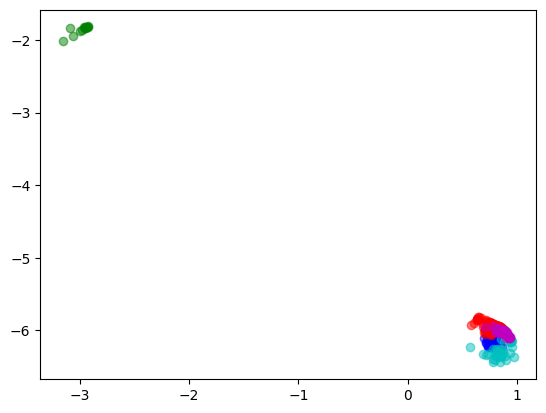

In [37]:
# Perform KMeans clustering on the embeddings
kmeans = KMeans(n_clusters=num_clusters, n_init=n).fit(z.cpu().detach().numpy())

# End Time
end_time = datetime.datetime.now()

# Plot the clusters
colors = colours_simp
for i in range(num_clusters):
    plt.scatter(z[kmeans.labels_ == i, 0].cpu().detach().numpy(),
                z[kmeans.labels_ == i, 1].cpu().detach().numpy(),
                c=colors[i % len(colours_simp)], alpha=0.5)
plt.show()

## Testing Analysis

In [38]:
# Print information
print('Test Parameters')
print('Number of Clusters ', num_clusters)
print('Number of Initializations of Cluster',n)
print('Transform Set',transform_set)
print('Transform Value Number',value_num)
print('Transform Test Number',test_num)
print('Learning Rate',learn_rate)
print('Epochs/Generations of Training',epochs)
print('\n')

print('------------')
# print('Device Details', device, 'Memory',virtual_memory().total / 1e9, 'GB')
# GPU Details
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
print('\n')

print('------------')
print('dataset',dataset)
print('data', data)
print('train data',train_data)
print('test data', test_data)
print('\n')

print('------------')
print('Start Time ', start_time)
print('End Time', end_time)
duration = end_time - start_time
print('Duration Time', duration)
print('\n')

print('------------')
train_pos_edge_index = train_data.pos_edge_label_index
print('training positive edges:', train_pos_edge_index)
print('\n')

print('------------')
test_pos_edge_index = test_data.pos_edge_label_index
print('testing positive edges:', test_pos_edge_index)
print('\n')

print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print('------------')


# FUTURE PARAMETERS
# Density, AVG Distance from Infrastructure, Avg # Hops, Dwell Time, Avg Direction, Avg Signal Strength, Avg Percentage Change/loss


Test Parameters
Number of Clusters  5
Number of Initializations of Cluster 10
Transform Set True
Transform Value Number 0.1
Transform Test Number 0.2
Learning Rate 0.01
Epochs/Generations of Training 100


------------
Thu Jul  6 18:10:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    51W / 400W |   1435MiB / 40960MiB |      0%      Default |
|                            

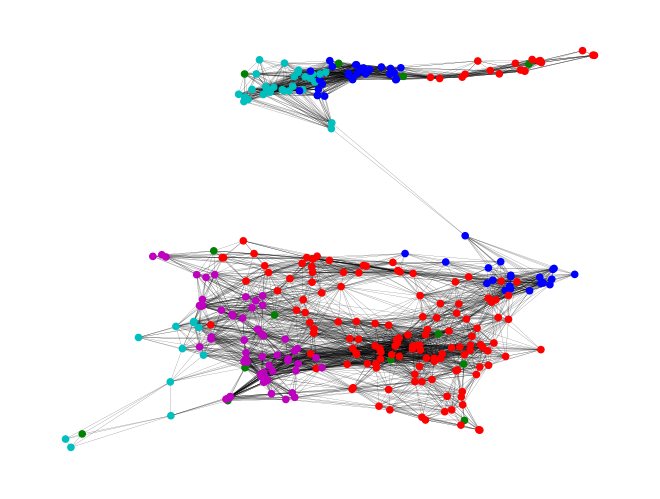

In [39]:
clusters = kmeans.labels_ #return the assigned values of clustering for representation

# # Print the nodes and their assigned clusters
# for i in range(len(G.nodes)):
#     print("Node", i, "belongs to cluster", clusters[i])

# Plot the graph with the nodes colored based on the clusters
colors_full = ["black" if c <= -1 else "b" if c == 0 else "g" if c == 1 else "r" if c == 2 else "c" if c == 3 else "m" if c == 4 else "y" if c == 5 else "k" for c in clusters]

nx.draw(G, with_labels=False, node_color=colors_full, node_size=20, width=0.1)
plt.show()